In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')


In [2]:
# Load the data
data = pd.read_csv('/home/arjun/Documents/Bitcoin price prediction ARIMA/Bitcoin_data')

# Unix-time to 
data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')

#Set the Index
data.set_index(['Timestamp'], inplace=True)
data

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
...,...,...,...,...,...,...,...
2017-10-19 23:56:00,5690.88,5690.88,5690.88,5690.88,0.168941,961.421706,5690.880000
2017-10-19 23:57:00,5698.13,5704.10,5695.63,5704.10,2.311662,13174.852877,5699.300163
2017-10-19 23:58:00,5695.62,5695.64,5694.00,5695.64,0.129647,738.409647,5695.533637


In [3]:
data = data.resample('D').mean()

# Resampling to monthly frequency
data_month = data.resample('M').mean()

# Resampling to annual frequency
data_year = data.resample('A-DEC').mean()

# Resampling to quarterly frequency
data_Q = data.resample('Q-DEC').mean()

In [4]:
#check the dataset
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.472552,4.472624,4.472552,4.472624,7.590527,34.069690,4.472579
2012-01-01,4.680778,4.680778,4.680778,4.680778,5.861697,27.856539,4.680778
2012-01-02,5.000000,5.000000,5.000000,5.000000,11.566478,57.832389,5.000000
2012-01-03,5.145917,5.145917,5.145917,5.145917,13.506125,68.725391,5.145917
2012-01-04,5.176708,5.228729,5.176708,5.228729,17.221039,91.624089,5.195443


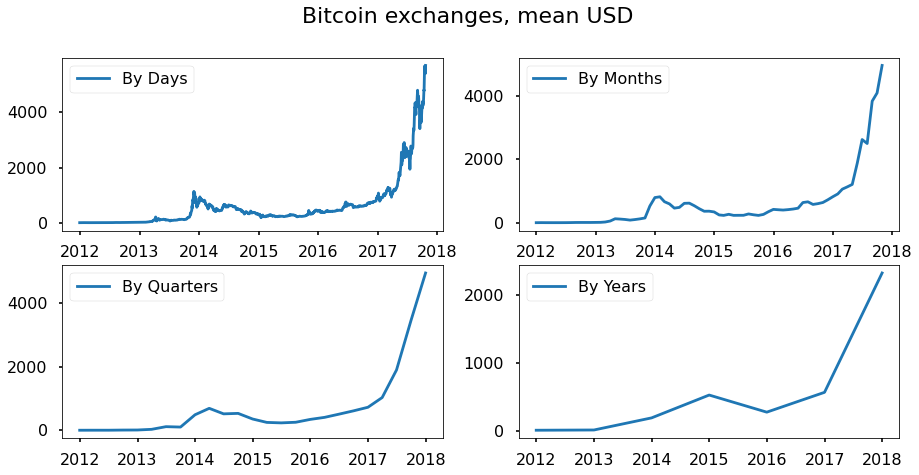

In [5]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(data.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(data_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(data_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(data_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

In [6]:
# Box-Cox Transformations
data_month['Weighted_Price_box'], lmbda = stats.boxcox(data_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey–Fuller test: p=1.000000


In [8]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [9]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
        try:
            model=sm.tsa.statespace.SARIMAX(data_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])


In [10]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
49  (2, 2, 0, 1)  145.153912
19  (1, 0, 0, 1)  146.056105
21  (1, 0, 1, 1)  146.829583
51  (2, 2, 1, 1)  147.106620
50  (2, 2, 1, 0)  147.130058
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   71
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -66.577
Date:                              Sat, 04 Mar 2023   AIC                            145.154
Time:                                      09:53:09   BIC                            157.517
Sample:                                  12-31-2011   HQIC                           149.969
                                       - 10-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

In [11]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

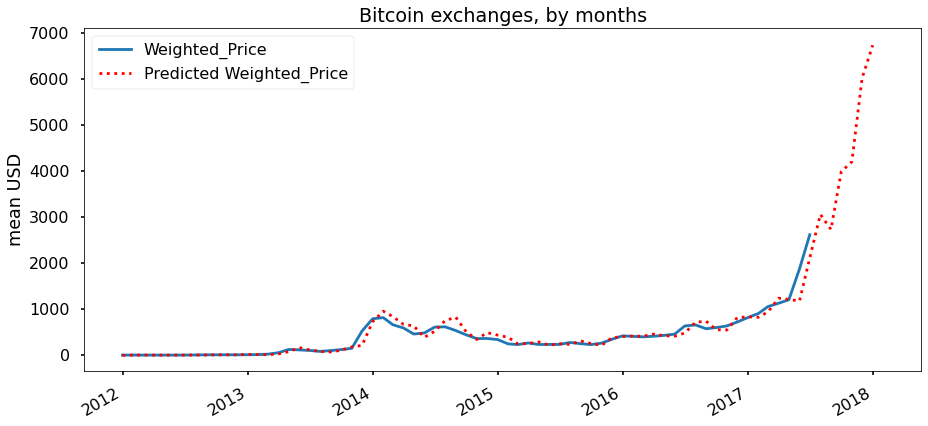

In [16]:
# Prediction
data_month2 = data_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= data_month.columns)
data_month2 = pd.concat([data_month2, future])
data_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
data_month2.Weighted_Price.plot()
data_month2.forecast.plot(color='r', ls='dotted', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()